<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/ECE_(cifar_binary).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR binary classification (Airplane or not):
Original CIFAR10 [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck] <br>
CIFAR Binary classification [0: airplane, 1: others]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
parser = argparse.ArgumentParser(description='BalancedLSF Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=200, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
parser.add_argument('--num_epoch', default=100, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=2, help='number classes')
args = parser.parse_args(args=[])

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        targets[targets > 0] = 1 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            targets[targets > 0] = 1
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

Training

In [ ]:
seed_everything()
mean_cifar10, std_cifar10 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar10, std_cifar10), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10),])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=4)

model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_epoch, best_acc = 0.0, 0
for epoch in range(args.num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    if accuracy > best_acc:
        patience = 0
        best_acc = accuracy
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'best_model_cifar_binary.pth.tar')
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
            epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0  acc: 0.9067  best epoch: 0  best acc: 0.9067
epoch: 1  acc: 0.9089  best epoch: 1  best acc: 0.9089
epoch: 2  acc: 0.9118  best epoch: 2  best acc: 0.9118
epoch: 3  acc: 0.9148  best epoch: 3  best acc: 0.9148
epoch: 4  acc: 0.9157  best epoch: 4  best acc: 0.9157
epoch: 5  acc: 0.9164  best epoch: 5  best acc: 0.9164
epoch: 6  acc: 0.8995  best epoch: 5  best acc: 0.9164
epoch: 7  acc: 0.9343  best epoch: 7  best acc: 0.9343
epoch: 8  acc: 0.9320  best epoch: 7  best acc: 0.9343
epoch: 9  acc: 0.9376  best epoch: 9  best acc: 0.9376
epoch: 10  acc: 0.9407  best epoch: 10  best acc: 0.9407
epoch: 11  acc: 0.9461  best epoch: 11  best acc: 0.9461
epoch: 12  acc: 0.9440  best epoch: 11  best acc: 0.9461
epoch: 13  acc: 0.9479  best epoch: 13  best acc: 0.9479
epoch: 14  acc: 0.9513  best epoch: 14  best acc: 0.9513
epoch: 15  acc: 0.9484  best epoch: 14  best acc: 0.9513
epoch: 16  acc: 0.9536  best epoch: 16  best acc: 0.9536
epoch: 17  acc: 0.9537  best epoch: 17  best acc: 0

# ECE
Github: https://github.com/gpleiss/temperature_scaling <br>
Paper: https://arxiv.org/pdf/1706.04599.pdf


In [ ]:
import matplotlib.pyplot as plt
def reliability_diagram(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10):
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('reliability_diagram_{}.png'.format(legend),dpi=300)

def ece_eval(preds, targets, n_bins=10,):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds,1), np.argmax(preds,1)
    confidences, predictions = confidences, predictions
    accuracies = (predictions == targets) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm

ECE for all classes:

Testing sample size: 10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ECE for class all: 0.0181


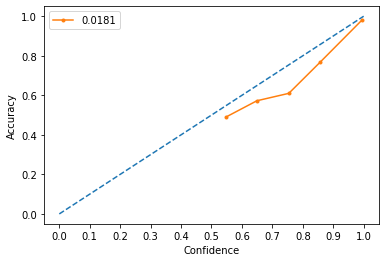

In [ ]:
def evaluation_all(model, testloader):
    model.eval()
    logits_list = []
    labels_list = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            targets[targets > 0] = 1
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            outputs = F.softmax(outputs, dim=1)
            logits_list.append(outputs)
            labels_list.append(targets)

        logits = torch.cat(logits_list).cpu().numpy()
        labels = torch.cat(labels_list).cpu().numpy()
    return correct / total, logits, labels
print('Testing sample size:',len(test_loader.dataset))
accuracy, logits, labels = evaluation_all(model, test_loader)

ece, acc, conf, Bm = ece_eval(logits, labels)
reliability_diagram(conf, acc, legend='{:.4f}'.format(ece))
print("ECE for class all:",round(ece,4))

ECE for class 0 (Airplane):

ECE for class 0: 0.1525


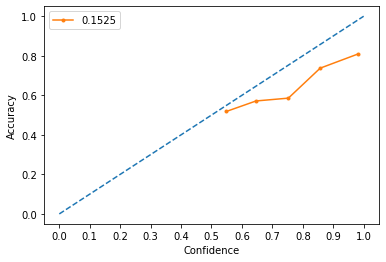

In [ ]:
ece, acc, conf, Bm = ece_eval(logits[labels==0], labels[labels==0])
reliability_diagram(conf, acc, legend='{:.4f}'.format(ece))
print('ECE for class 0:',round(ece,4))

ECE for class 1 (others):

ECE for class 1: 0.0031


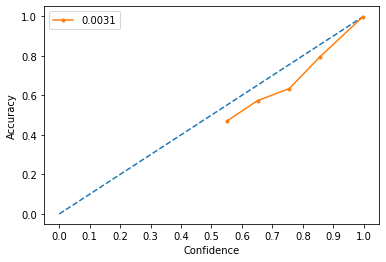

In [ ]:
ece, acc, conf, Bm = ece_eval(logits[labels==1], labels[labels==1])
reliability_diagram(conf, acc, legend='{:.4f}'.format(ece))
print('ECE for class 1:',round(ece,4))

# ECE 
Reference: Tensorflow-probability (https://www.tensorflow.org/probability/api_docs/python/tfp/stats/expected_calibration_error) 

ECE for class all:

In [ ]:
import tensorflow_probability as tfp

def evaluation_all(model, testloader):
    model.eval()
    logits_list = []
    labels_list = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            targets[targets > 0] = 1
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            logits_list.append(outputs)
            labels_list.append(targets)

        logits = torch.cat(logits_list).cpu().numpy()
        labels = torch.cat(labels_list).cpu().numpy()
    return correct / total, logits, labels

acc, logits_tf, labels_tf = evaluation_all(model, test_loader)
ece = tfp.stats.expected_calibration_error(10, logits=logits_tf, labels_true=labels_tf, labels_predicted=np.argmax(logits_tf,1))
print("ECE for class all:{:.4f}".format(np.array(ece)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ECE for class all:0.0181


ECE for class 0:

In [ ]:
ece = tfp.stats.expected_calibration_error(10, logits=logits_tf[labels==0], labels_true=labels_tf[labels==0], labels_predicted=np.argmax(logits_tf[labels==0],1))
print("ECE for class 0: {:.4f}".format(np.array(ece)))

ECE for class 0: 0.1525


ECE for class 1:

In [ ]:
ece = tfp.stats.expected_calibration_error(10, logits=logits_tf[labels==1], labels_true=labels_tf[labels==1], labels_predicted=np.argmax(logits_tf[labels==1],1))
print("ECE for class 1: {:.4f}".format(np.array(ece)))

ECE for class 1: 0.0032
